#### Imports

In [30]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import MDS, TSNE
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import  train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
import random

#### Load the Data

In [31]:
data = np.load('p2_unsupervised/X.npy')
data = pd.DataFrame(data)

# Data Transform  x = log(x + 1)
log_data = np.log2(data + 1)

print(f'Number of rows and cells: {log_data.shape}')
print(f'Largest entry of first column: {max(log_data.iloc[:,0])}')

Number of rows and cells: (2169, 45768)
Largest entry of first column: 5.972169178513185


#### Dimensionality Reduction with PCA
Goal: get all the PC's that sum up the 90% of the explained variance

In [32]:
pca = PCA(n_components=log_data.shape[0])
components = pca.fit_transform(log_data)
explained_var = pca.explained_variance_ratio_

last_pc_idx = None

for i, var in enumerate(np.cumsum(explained_var)):
    if var >= 0.9:
        last_pc_idx = i
        print(f"PC with 90% of variance: {i}")
        break

X = pd.DataFrame(components).iloc[:,0:last_pc_idx]
print(f'Reduced Data Dim: {X.shape}')

PC with 90% of variance: 1475
Reduced Data Dim: (2169, 1475)


#### K-means Clustering
Running K-Means method: Find the optimal k clusters

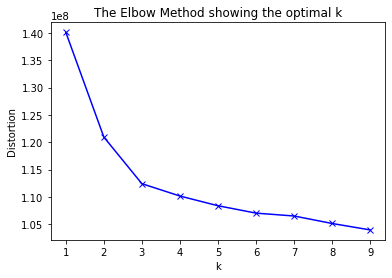

In [33]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

The Elbow Plot shows that the optimal k is 3

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


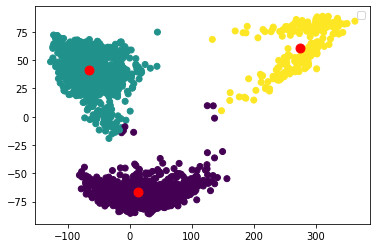

In [34]:
kmeans = KMeans(n_clusters=3)
y_pred = kmeans.fit_predict(X)
centroids = kmeans.cluster_centers_

plt.scatter(X.iloc[:,0], X.iloc[:,1], c=y_pred)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = "red")
plt.legend()
plt.show()

The plot shows that the 3 clusters are well defined. Next we assign the labels

In [35]:
unique, counts = np.unique(y_pred, return_counts=True)
print(f'# of each label: {dict(zip(unique, counts))}')
labels = []
for i in y_pred:
    if i == 0:
        labels.append('Class 0')
    elif i == 1:
        labels.append('Class 1')
    else:
        labels.append('Class 2')

unique, counts = np.unique(labels, return_counts=True)
print(f'# of each label: {dict(zip(unique, counts))}')

# of each label: {0: 866, 1: 1087, 2: 216}
# of each label: {'Class 0': 866, 'Class 1': 1087, 'Class 2': 216}


#### Run a Logistic Regression Model
Split the data in train and test

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    log_data, labels, test_size=0.3, random_state=20
)

Fit a Logit

In [37]:
model = LogisticRegression(
    multi_class='ovr', 
    random_state=20,
    penalty='l2',
    max_iter=300)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average='micro')
rec = recall_score(y_test, y_pred, average='micro')
auc = roc_auc_score(y_test,y_pred_proba, multi_class='ovr')

print(f'Accuracy: {acc}\nPrecision: {pre}\nRecall: {rec}\nAUC: {auc}')

Accuracy: 0.9938556067588326
Precision: 0.9938556067588326
Recall: 0.9938556067588326
AUC: 0.9998687947776728


The model shows a great performance!!

#### Load Evaluation Data

In [38]:
X_train_ev = np.load('p2_evaluation/X_train.npy')
X_test_ev = np.load('p2_evaluation/X_test.npy')
y_train_ev = np.load('p2_evaluation/y_train.npy')
y_test_ev = np.load('p2_evaluation/y_test.npy')

# Transform the data
X_train_ev = np.log2(X_train_ev + 1)
X_test_ev = np.log2(X_test_ev + 1)

print(f'Evaluation Training Data Shape: {X_train_ev.shape}')
print(f'Evaluation Testing Data Shape: {X_test_ev.shape}')

Evaluation Training Data Shape: (1077, 45768)
Evaluation Testing Data Shape: (1108, 45768)


#### Fit a logit with 100 important features
The importance of features are determined by the model coeffients. Ranke the coefficients using the maximum absolute value over classes, or the sum of absolute values.

In [39]:
importance = abs(model.coef_[0])
imp_features = np.argsort(importance)[::-1][0:100]

imp_model = LogisticRegression(
    multi_class='ovr', 
    random_state=20,
    penalty='l2',
    max_iter=1200)

imp_model.fit(X_train_ev[:, imp_features], y_train_ev)

y_pred_imp_ev = imp_model.predict(X_test_ev[:, imp_features])
y_pred_proba_imp_ev = imp_model.predict_proba(X_test_ev[:, imp_features])

acc = accuracy_score(y_test_ev, y_pred_imp_ev)
pre = precision_score(y_test_ev, y_pred_imp_ev, average='micro')
rec = recall_score(y_test_ev, y_pred_imp_ev, average='micro')
auc = roc_auc_score(y_test_ev,y_pred_proba_imp_ev, multi_class='ovr')

print(f'Accuracy: {acc}\nPrecision: {pre}\nRecall: {rec}\nAUC: {auc}')

Accuracy: 0.9043321299638989
Precision: 0.9043321299638989
Recall: 0.9043321299638989
AUC: 0.997056357220118


#### Fit a logit with 100 Random features
Take 100 random Features

In [40]:
random.seed(20)
rand_features = random.sample(range(0, len(X_train_ev[0,:])), 100)

rand_model = LogisticRegression(
    multi_class='ovr', 
    random_state=20,
    penalty='l2',
    max_iter=300)

rand_model.fit(X_train_ev[:, rand_features], y_train_ev)

y_pred_imp_ev = rand_model.predict(X_test_ev[:, rand_features])
y_pred_proba_imp_ev = rand_model.predict_proba(X_test_ev[:, rand_features])

acc = accuracy_score(y_test_ev, y_pred_imp_ev)
pre = precision_score(y_test_ev, y_pred_imp_ev, average='micro')
rec = recall_score(y_test_ev, y_pred_imp_ev, average='micro')
auc = roc_auc_score(y_test_ev,y_pred_proba_imp_ev, multi_class='ovr')

print(f'Accuracy: {acc}\nPrecision: {pre}\nRecall: {rec}\nAUC: {auc}')


Accuracy: 0.37725631768953066
Precision: 0.37725631768953066
Recall: 0.37725631768953066
AUC: 0.8813941512590959


#### Compare the two models
The model with the important features have a better performances, due to the features have more variance that the random selected features.
In the next plot we can see the variance of the features of the two models.

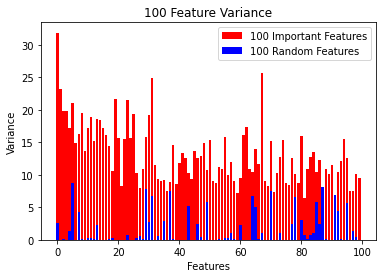

In [41]:
imp_features_var = pd.DataFrame(X_train_ev[:, imp_features]).var().reset_index()
imp_features_var.columns = ['Index', 'Variance']
# print(imp_features_var.head())

rand_features_var = pd.DataFrame(X_train_ev[:, rand_features]).var().reset_index()
rand_features_var.columns = ['Index', 'Variance']
# print(rand_features_var.head())

plt.bar(imp_features_var.Index, imp_features_var.Variance, color = 'red', label = '100 Important Features')
plt.bar(rand_features_var.Index, rand_features_var.Variance, color = 'blue', label = '100 Random Features')

plt.xlabel("Features")
plt.ylabel("Variance")
plt.title("100 Feature Variance")
plt.legend()
plt.show()